In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import torch
print("pytorch ver . ",torch.__version__)
print("Is CUDA available?",torch.cuda.is_available())
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader
import torch.utils.data as Data
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import xarray as xr
import os
os.environ['R_HOME'] = '/home/luhung3080/miniconda3/envs/chou/lib/R'
from rpy2.robjects import r, numpy2ri
numpy2ri.activate()
from rpy2.robjects.packages import importr
sinkr = importr('sinkr')
import Nio
print ("pynio ver . ",Nio.__version__)

/home/luhung3080/miniconda3/envs/chou/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


pytorch ver .  1.11.0+cu113
Is CUDA available? True
pynio ver .  1.5.5


# Y = b0 + b1X12
# X1跟X2串在一起 = 24hr + 96hr , function on function

## Data

In [27]:
data=pd.read_csv('v100_hr_20200101-0930_cut_utf8.csv')

/home/luhung3080/miniconda3/envs/chou/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3524: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## 開始就把x1 x2分開 用x1推y

In [28]:
x1=np.zeros([243,1704])
x2=np.zeros([243,6816])

#x1 (0th~1703th column as x)
for i in range (0,243):
    for j in range (0,71):
        a=np.array(data['obs_PMf'][6816*i+96*j:6816*i+96*j+24])
        for k in range (0,24):
            if a[k]=='\\N' :
                a[k]=np.nan
        for k in range (0,24):
            x1[i][j*24+k]=a[k]

#x2 (1704th~8519th column as x)
for i in range (1,244):
    b=np.array(data['cal_PMf'][6816*i:6816*i+6816])
    for j in range(0,6816):
        if b[j]=='\\N' :
            b[j]=np.nan
    for j in range(0,6816):
        x2[i-1][j]=b[j]
        
print(np.shape(x1))
print(np.shape(x2))

(243, 1704)
(243, 6816)


In [29]:
x1Restruct=sinkr.dineof(x1)
x2Restruct=sinkr.dineof(x2)

[1] "1 EOF ; RMS = 7.10272576"
[1] "1 EOF ; RMS = 7.05862242"
[1] "1 EOF ; RMS = 7.05938733"
[1] "2 EOF ; RMS = 6.21747958"
[1] "2 EOF ; RMS = 6.21590823"
[1] "2 EOF ; RMS = 6.2159887"
[1] "3 EOF ; RMS = 5.74523468"
[1] "3 EOF ; RMS = 5.7445795"
[1] "3 EOF ; RMS = 5.7451972"
[1] "4 EOF ; RMS = 5.44644981"
[1] "4 EOF ; RMS = 5.45441718"
[1] "5 EOF ; RMS = 5.22676887"
[1] "5 EOF ; RMS = 5.22992753"
[1] "6 EOF ; RMS = 5.01831585"
[1] "6 EOF ; RMS = 5.01308638"
[1] "6 EOF ; RMS = 5.01268367"
[1] "6 EOF ; RMS = 5.01267015"
[1] "6 EOF ; RMS = 5.0126869"
[1] "7 EOF ; RMS = 4.94090499"
[1] "7 EOF ; RMS = 4.94890144"
[1] "8 EOF ; RMS = 4.87051569"
[1] "8 EOF ; RMS = 4.87506519"
[1] "9 EOF ; RMS = 4.82344355"
[1] "9 EOF ; RMS = 4.83516354"
[1] "10 EOF ; RMS = 4.79850962"
[1] "10 EOF ; RMS = 4.81113483"
[1] "11 EOF ; RMS = 4.78258657"
[1] "11 EOF ; RMS = 4.800591"
[1] "12 EOF ; RMS = 4.77042508"
[1] "12 EOF ; RMS = 4.79116859"
[1] "13 EOF ; RMS = 4.80152375"
[1] "1 EOF ; RMS = 10.50829422"
[1] "1

## Restruct Function

In [30]:
x1Restruct_Fun=np.array(x1Restruct[0])
x2Restruct_Fun=np.array(x2Restruct[0])
print(np.shape(x1Restruct_Fun))
print(np.shape(x2Restruct_Fun))

(243, 1704)
(243, 6816)


In [31]:
YRestruct_Fun=np.zeros([239,6816])
for i in range (0,239):
    for j in range (0,1704):
        YRestruct_Fun[i][j]=x1Restruct_Fun[i+1][j]
    for j in range (1704,3408):
        YRestruct_Fun[i][j]=x1Restruct_Fun[i+2][j-1704]
    for j in range (3408,5112):
        YRestruct_Fun[i][j]=x1Restruct_Fun[i+3][j-3408]
    for j in range (5112,6816):
        YRestruct_Fun[i][j]=x1Restruct_Fun[i+4][j-5112]
print(np.shape(YRestruct_Fun))

(239, 6816)


In [32]:
XRestruct_Fun=np.zeros([239,8520])
for i in range (0,239):
    for j in range (0,1704):
        XRestruct_Fun[i][j]=x1Restruct_Fun[i][j]
    for j in range (1704,8520):
        XRestruct_Fun[i][j]=x2Restruct_Fun[i][j-1704]
print(np.shape(XRestruct_Fun))

(239, 8520)


In [33]:
XMean_fun=np.zeros(8520)
for i in range(0,8520):
    for j in range(0,239):
        XMean_fun[i]=XMean_fun[i]+(XRestruct_Fun[j][i]/239)
YMean_fun=np.zeros(6816)
for i in range(0,6816):
    for j in range(0,239):
        YMean_fun[i]=YMean_fun[i]+(YRestruct_Fun[j][i]/239)
print(np.shape(XMean_fun))
print(np.shape(YMean_fun))

(8520,)
(6816,)


In [34]:
XRestruct_FunC=XRestruct_Fun
YRestruct_FunC=YRestruct_Fun
for i in range (0,239):
    for j in range (0,8520):
        XRestruct_FunC[i][j]=XRestruct_FunC[i][j]-XMean_fun[j]
    for j in range (0,6816):
        YRestruct_FunC[i][j]=YRestruct_FunC[i][j]-YMean_fun[j]
print(np.shape(XRestruct_FunC))
print(np.shape(YRestruct_FunC))

(239, 8520)
(239, 6816)


In [35]:
Xhat=XRestruct_FunC
Yhat=YRestruct_FunC
Xbar=XMean_fun
Ybar=YMean_fun
print('Xhat')
#print(Xhat)
print(np.shape(Xhat))
print('Yhat')
#print(Yhat)
print(np.shape(Yhat))
print('Xbar')
#print(Xbar)
print(np.shape(Xbar))
print('Ybar')
#print(Ybar)
print(np.shape(Ybar))

Xhat
(239, 8520)
Yhat
(239, 6816)
Xbar
(8520,)
Ybar
(6816,)


In [36]:
print(np.linalg.matrix_rank(Xhat))
print(np.linalg.matrix_rank(Yhat))

238
238


# PCA95

## pca

In [37]:
pca95 = PCA(n_components=0.95)
pca95.fit(Xhat)

PCA(n_components=0.95)

In [38]:
x_pca95=pca95.transform(Xhat)
print(x_pca95.shape)
print(np.linalg.matrix_rank(x_pca95))

(239, 111)
111


## beta

In [39]:
beta1_1=np.dot( np.linalg.inv( np.dot( x_pca95.T,x_pca95 ) )  ,  np.dot( x_pca95.T,Yhat )  )
print(np.shape(beta1_1))

(111, 6816)


## fit Y (base on training data)

In [40]:
new_Ybar=np.zeros([239,6816])
for i in range (0,239):
    new_Ybar[i]=Ybar
print(np.shape(new_Ybar))

(239, 6816)


In [42]:
fit95=new_Ybar+np.dot(x_pca95  , beta1_1)
print(np.shape(fit95))

(239, 6816)


## compare

In [44]:
fit95_test=fit95
"""
old data
"""
old_x=np.zeros([239,6816])
old_y=np.zeros([239,6816])
#data_cal
for i in range (1,240):
    a=np.array(data['cal_PMf'][6816*i:6816*i+6816])
    for j in range(0,6816):
        if a[j]=='\\N' :
            a[j]=np.nan
    old_x[i-1]=a
#data_obs
for i in range (1,240):
    a=np.array(data['obs_PMf'][6816*i:6816*i+6816])
    for j in range(0,6816):
        if a[j]=='\\N' :
            a[j]=np.nan
    old_y[i-1]=a
print(np.shape(old_x))
print(np.shape(old_y))
print(np.shape(fit95_test))

(239, 6816)
(239, 6816)
(239, 6816)


## compare(training data)

In [45]:
old_x1=np.zeros([239,6816])
old_y1=np.zeros([239,6816])
fit_fx1=np.zeros([239,6816])
for i in range (0,239):
    for j in range (0,6816):
        old_x1[i][j]=old_x[i][j]
        old_y1[i][j]=old_y[i][j]
        fit_fx1[i][j]=fit95_test[i][j]
before1=abs(old_x1-old_y1)
after1=abs(fit_fx1-old_y1)

before_error1=np.nanmean(before1)
after_error1=np.nanmean(after1)

print("January to August (training data set) before_error (MADE) of 95: %f" %before_error1)
print("January to August (training data set) after_error (MADE) of 95: %f" %after_error1)

January to August (training data set) before_error (MADE) of 95: 8.243510
January to August (training data set) after_error (MADE) of 95: 8.119592


## compare(testing data)

In [ ]:
old_x2=np.zeros([239,6816])
old_y1=np.zeros([239,6816])
fit_fx1=np.zeros([239,6816])
for i in range (0,239):
    for j in range (0,6816):
        old_x1[i][j]=old_x[i][j]
        old_y1[i][j]=old_y[i][j]
        fit_fx1[i][j]=fit95_test[i][j]
before1=abs(old_x1-old_y1)
after1=abs(fit_fx1-old_y1)

before_error1=np.nanmean(before1)
after_error1=np.nanmean(after1)

print("January to August (training data set) before_error (MADE) of 95: %f" %before_error1)
print("January to August (training data set) after_error (MADE) of 95: %f" %after_error1)

In [ ]:
xcal=xf
for i in range (0,30):
    for j in range (0,8520):
        xcal[i][j]=xcal[i][j]-Xbar[j]
print(np.shape(xcal))        
#(30,8520)

new_xcal=np.zeros([30,205])
for i in range (0,30):
    daycal=np.zeros([1,8520])
    for j in range (0,8520):
        daycal[0][j]=xcal[i][j]
    new_xcal[i]=pca95.transform(daycal)
print(new_xcal.shape)
#(30, 205)

new_Ybar=np.zeros([30,6816])
for i in range (0,30):
    new_Ybar[i]=Ybar
    
new_xfit=new_Ybar+np.dot(new_xcal, beta1_1)
print(np.shape(new_xfit))
#(30,6816)

In [ ]:
# PCA95
## pca
pca95 = PCA(n_components=0.95)
pca95.fit(new_x)

x_pca95=pca95.transform(new_x)
print(x_pca95.shape)
print(np.linalg.matrix_rank(x_pca95))
## beta
beta1_1=np.dot( np.linalg.inv( np.dot( x_pca95.T,x_pca95 ) )  ,  np.dot( x_pca95.T,new_y )  )
print(np.shape(beta1_1))
##fit Y (base on training data)
new_Ybar=np.zeros([239*96,6816])
for i in range (0,239*96):
    new_Ybar[i]=Ybar
print(np.shape(new_Ybar))

fit_y1=new_Ybar+np.dot(x_pca95  , beta1_1)
print(np.shape(fit_y1))

fit95=np.zeros([239,6816])
for i in range (0,96):
    for j in range (0,239):
        for k in range (0,71):
            fit95[j][96*k+i]=fit_y1[239*i+j][96*k+i]
print(np.shape(fit95))

fit95_mean=np.zeros([239,6816])
for i in range (0,239):
    for j in range (0,6816):
        for k in range (0,96):
            fit95_mean[i][j]=fit95_mean[i][j]+fit_y1[239*k+i][j]/96
print(np.shape(fit95_mean))
##compare(training data)
fit95_test=fit95
fit95_mean_test=fit95_mean

"""
old data
"""
old_x=np.zeros([239,6816])
old_y=np.zeros([239,6816])
#data_cal
for i in range (1,240):
    a=np.array(data['cal_PMf'][6816*i:6816*i+6816])
    for j in range(0,6816):
        if a[j]=='\\N' :
            a[j]=np.nan
    old_x[i-1]=a
#data_obs
for i in range (1,240):
    a=np.array(data['obs_PMf'][6816*i:6816*i+6816])
    for j in range(0,6816):
        if a[j]=='\\N' :
            a[j]=np.nan
    old_y[i-1]=a
print(np.shape(old_x))
print(np.shape(old_y))
print(np.shape(fit95_test))
print(np.shape(fit95_mean_test))

old_x1=np.zeros([239,6816])
old_y1=np.zeros([239,6816])
fit_fx1=np.zeros([239,6816])
fit_fx1mean=np.zeros([239,6816])
for i in range (0,239):
    for j in range (0,6816):
        old_x1[i][j]=old_x[i][j]
        old_y1[i][j]=old_y[i][j]
        fit_fx1[i][j]=fit95_test[i][j]
        fit_fx1mean[i][j]=fit95_mean_test[i][j]
before1=abs(old_x1-old_y1)
after1=abs(fit_fx1-old_y1)
after_mean1=abs(fit_fx1mean-old_y1)

before_error1=np.nanmean(before1)
after_error1=np.nanmean(after1)
after_error_mean1=np.nanmean(after_mean1)

print("January to August (training data set) before_error (MADE) of 95: %f" %before_error1)
print("January to August (training data set) after_error (MADE) of 95: %f" %after_error1)
print("January to August (training data set) after_error (MADE) of 95_mean: %f" %after_error_mean1)



# Y = b0 + b1X1 + b2X2 
# X1(24hr)跟X2(96hr)分開 , concurrent + function on function

## Data

In [2]:
data=pd.read_csv('v100_hr_20200101-0930_cut_utf8.csv')

/home/luhung3080/miniconda3/envs/chou/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3524: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## 開始就把x1 x2分開 用x1推y

In [3]:
x1=np.zeros([243,1704])
x2=np.zeros([243,6816])

#x1 (0th~1703th column as x)
for i in range (0,243):
    for j in range (0,71):
        a=np.array(data['obs_PMf'][6816*i+96*j:6816*i+96*j+24])
        for k in range (0,24):
            if a[k]=='\\N' :
                a[k]=np.nan
        for k in range (0,24):
            x1[i][j*24+k]=a[k]

#x2 (1704th~8519th column as x)
for i in range (1,244):
    b=np.array(data['cal_PMf'][6816*i:6816*i+6816])
    for j in range(0,6816):
        if b[j]=='\\N' :
            b[j]=np.nan
    for j in range(0,6816):
        x2[i-1][j]=b[j]
        
print(np.shape(x1))
print(np.shape(x2))

(243, 1704)
(243, 6816)


## dineof

In [4]:
x1Restruct=sinkr.dineof(x1)
x2Restruct=sinkr.dineof(x2)

[1] "1 EOF ; RMS = 7.31917658"
[1] "1 EOF ; RMS = 7.2618831"
[1] "1 EOF ; RMS = 7.26010319"
[1] "1 EOF ; RMS = 7.25996821"
[1] "1 EOF ; RMS = 7.25995303"
[1] "1 EOF ; RMS = 7.2599509"
[1] "2 EOF ; RMS = 6.39199923"
[1] "2 EOF ; RMS = 6.38629034"
[1] "2 EOF ; RMS = 6.3860575"
[1] "2 EOF ; RMS = 6.38604286"
[1] "2 EOF ; RMS = 6.38604121"
[1] "3 EOF ; RMS = 5.91695283"
[1] "3 EOF ; RMS = 5.91946385"
[1] "4 EOF ; RMS = 5.61404954"
[1] "4 EOF ; RMS = 5.61382878"
[1] "4 EOF ; RMS = 5.61418256"
[1] "5 EOF ; RMS = 5.32725566"
[1] "5 EOF ; RMS = 5.32639053"
[1] "5 EOF ; RMS = 5.32682313"
[1] "6 EOF ; RMS = 5.15506199"
[1] "6 EOF ; RMS = 5.15145602"
[1] "6 EOF ; RMS = 5.15085258"
[1] "6 EOF ; RMS = 5.15066682"
[1] "6 EOF ; RMS = 5.15060506"
[1] "6 EOF ; RMS = 5.15058457"
[1] "6 EOF ; RMS = 5.15057783"
[1] "7 EOF ; RMS = 5.03927307"
[1] "7 EOF ; RMS = 5.03954542"
[1] "8 EOF ; RMS = 4.98309365"
[1] "8 EOF ; RMS = 4.99044254"
[1] "9 EOF ; RMS = 4.9008916"
[1] "9 EOF ; RMS = 4.89348262"
[1] "9 EOF ;

## Restruct Function

In [5]:
x1Restruct_Fun=np.array(x1Restruct[0])
x2Restruct_Fun=np.array(x2Restruct[0])
print(np.shape(x1Restruct_Fun))
print(np.shape(x2Restruct_Fun))

(243, 1704)
(243, 6816)


In [6]:
YRestruct_Fun=np.zeros([239,6816])
for i in range (0,239):
    for j in range (0,1704):
        YRestruct_Fun[i][j]=x1Restruct_Fun[i+1][j]
    for j in range (1704,3408):
        YRestruct_Fun[i][j]=x1Restruct_Fun[i+2][j-1704]
    for j in range (3408,5112):
        YRestruct_Fun[i][j]=x1Restruct_Fun[i+3][j-3408]
    for j in range (5112,6816):
        YRestruct_Fun[i][j]=x1Restruct_Fun[i+4][j-5112]
print(np.shape(YRestruct_Fun))

(239, 6816)


In [7]:
XRestruct_Fun=np.zeros([239,8520])
for i in range (0,239):
    for j in range (0,1704):
        XRestruct_Fun[i][j]=x1Restruct_Fun[i][j]
    for j in range (1704,8520):
        XRestruct_Fun[i][j]=x2Restruct_Fun[i][j-1704]
print(np.shape(XRestruct_Fun))

(239, 8520)


In [8]:
XMean_fun=np.zeros(8520)
for i in range(0,8520):
    for j in range(0,239):
        XMean_fun[i]=XMean_fun[i]+(XRestruct_Fun[j][i]/239)
YMean_fun=np.zeros(6816)
for i in range(0,6816):
    for j in range(0,239):
        YMean_fun[i]=YMean_fun[i]+(YRestruct_Fun[j][i]/239)
print(np.shape(XMean_fun))
print(np.shape(YMean_fun))

(8520,)
(6816,)


In [9]:
XRestruct_FunC=XRestruct_Fun
YRestruct_FunC=YRestruct_Fun
for i in range (0,239):
    for j in range (0,8520):
        XRestruct_FunC[i][j]=XRestruct_FunC[i][j]-XMean_fun[j]
    for j in range (0,6816):
        YRestruct_FunC[i][j]=YRestruct_FunC[i][j]-YMean_fun[j]
print(np.shape(XRestruct_FunC))
print(np.shape(YRestruct_FunC))

(239, 8520)
(239, 6816)


In [10]:
Xhat=XRestruct_FunC
Yhat=YRestruct_FunC
Xbar=XMean_fun
Ybar=YMean_fun
print('Xhat')
#print(Xhat)
print(np.shape(Xhat))
print('Yhat')
#print(Yhat)
print(np.shape(Yhat))
print('Xbar')
#print(Xbar)
print(np.shape(Xbar))
print('Ybar')
#print(Ybar)
print(np.shape(Ybar))

Xhat
(239, 8520)
Yhat
(239, 6816)
Xbar
(8520,)
Ybar
(6816,)


## sparse x1 x2

In [11]:
x1=np.zeros([239,1704])
x2=np.zeros([239,6816])
for i in range (0,239):
    for j in range (0,1704):
        x1[i][j]=Xhat[i][j]
    for j in range (0,6816):
        x2[i][j]=Xhat[i][1704+j]
print(np.shape(x1))
print(np.shape(x2))

(239, 1704)
(239, 6816)


## expend x1 x2

In [12]:
new_x=np.zeros([239*96,8520]) #22944
new_y=np.zeros([239*96,6816]) #22944
#new_x : 0th~1703th column
for i in range (0,96):
    for j in range (0,239):
        for k in range (0,1704):
            new_x[239*i+j][k]=x1[j][k]
#new_x : 1704th~8519th column
for i in range (0,96):
    for j in range (0,239):
        for k in range (0+i,6720+1+i,96): #6720=6816-96
            new_x[239*i+j][1704+k]=x2[j][k]
#new_y
for i in range (0,96):
    for j in range (0,239):
        for k in range (0,6816):
            new_y[239*i+j][k]=Yhat[j][k]
            
print(np.shape(new_x))
print(np.shape(new_y))

(22944, 8520)
(22944, 6816)


In [13]:
print(np.linalg.matrix_rank(new_x))
print(np.linalg.matrix_rank(new_y))

7054
238


# PCA(95%)

## pca

In [14]:
pca95 = PCA(n_components=0.95)
pca95.fit(new_x)

PCA(n_components=0.95)

In [15]:
x_pca95=pca95.transform(new_x)
print(x_pca95.shape)
print(np.linalg.matrix_rank(x_pca95))

(22944, 205)
205


## beta

In [19]:
beta1_1=np.dot( np.linalg.inv( np.dot( x_pca95.T,x_pca95 ) )  ,  np.dot( x_pca95.T,new_y )  )
print(np.shape(beta1_1))

(205, 6816)


## fit Y (base on training data)

In [20]:
new_Ybar=np.zeros([239*96,6816])
for i in range (0,239*96):
    new_Ybar[i]=Ybar
print(np.shape(new_Ybar))

(22944, 6816)


In [21]:
fit_y1=new_Ybar+np.dot(x_pca95  , beta1_1)
print(np.shape(fit_y1))

(22944, 6816)


In [22]:
fit95=np.zeros([239,6816])
for i in range (0,96):
    for j in range (0,239):
        for k in range (0,71):
            fit95[j][96*k+i]=fit_y1[239*i+j][96*k+i]
print(np.shape(fit95))

(239, 6816)


In [23]:
fit95_mean=np.zeros([239,6816])
for i in range (0,239):
    for j in range (0,6816):
        for k in range (0,96):
            fit95_mean[i][j]=fit95_mean[i][j]+fit_y1[239*k+i][j]/96
print(np.shape(fit95_mean))

(239, 6816)


## compare(training data)

In [24]:
fit95_test=fit95
fit95_mean_test=fit95_mean

In [25]:
"""
old data
"""
old_x=np.zeros([239,6816])
old_y=np.zeros([239,6816])
#data_cal
for i in range (1,240):
    a=np.array(data['cal_PMf'][6816*i:6816*i+6816])
    for j in range(0,6816):
        if a[j]=='\\N' :
            a[j]=np.nan
    old_x[i-1]=a
#data_obs
for i in range (1,240):
    a=np.array(data['obs_PMf'][6816*i:6816*i+6816])
    for j in range(0,6816):
        if a[j]=='\\N' :
            a[j]=np.nan
    old_y[i-1]=a
print(np.shape(old_x))
print(np.shape(old_y))
print(np.shape(fit95_test))
print(np.shape(fit95_mean_test))

(239, 6816)
(239, 6816)
(239, 6816)
(239, 6816)


In [26]:
old_x1=np.zeros([239,6816])
old_y1=np.zeros([239,6816])
fit_fx1=np.zeros([239,6816])
fit_fx1mean=np.zeros([239,6816])
for i in range (0,239):
    for j in range (0,6816):
        old_x1[i][j]=old_x[i][j]
        old_y1[i][j]=old_y[i][j]
        fit_fx1[i][j]=fit95_test[i][j]
        fit_fx1mean[i][j]=fit95_mean_test[i][j]
before1=abs(old_x1-old_y1)
after1=abs(fit_fx1-old_y1)
after_mean1=abs(fit_fx1mean-old_y1)

before_error1=np.nanmean(before1)
after_error1=np.nanmean(after1)
after_error_mean1=np.nanmean(after_mean1)

print("January to August (training data set) before_error (MADE) of 95: %f" %before_error1)
print("January to August (training data set) after_error (MADE) of 95: %f" %after_error1)
print("January to August (training data set) after_error (MADE) of 95_mean: %f" %after_error_mean1)

January to August (training data set) before_error (MADE) of 95: 8.243510
January to August (training data set) after_error (MADE) of 95: 8.259566
January to August (training data set) after_error (MADE) of 95_mean: 8.253749


## compare(testing data)

In [99]:
old_x=np.zeros([274,6816])
old_y=np.zeros([274,6816])
bigx=np.zeros([243,8520])
#data_cal
for i in range (0,274):
    a=np.array(data['cal_PMf'][6816*i:6816*i+6816])
    for j in range(0,6816):
        if a[j]=='\\N' :
            a[j]=np.nan
    old_x[i]=a
#data_obs
for i in range (0,274):
    a=np.array(data['obs_PMf'][6816*i:6816*i+6816])
    for j in range(0,6816):
        if a[j]=='\\N' :
            a[j]=np.nan
    old_y[i]=a
#x=x1 mix x2
for i in range (0,243):
    for j in range(0,1704):
        bigx[i][j]=old_y[i][j]
for i in range (1,244):  
    for j in range(1704,8520):
        bigx[i-1][j]=old_y[i][j-1704]
print(np.shape(old_x))
print(np.shape(old_y))
print(np.shape(bigx))

(274, 6816)
(274, 6816)
(243, 8520)


In [100]:
x=np.zeros([30,8520])
for i in range (0,30):
    for j in range (0,1704):
        x[i][j]=old_y[i+243][j]
    for j in range (1704,8520):
        x[i][j]=old_x[i+244][j-1704]
print(np.shape(x))

(30, 8520)


In [101]:
xf=np.zeros([30,8520])
xa=bigx
a=243
for i in range (30):
    xa=np.insert(xa,a,x[i],0)
    xb=sinkr.dineof(xa)
    xc=xb[0]
    xf[i]=xc[a]
    a=a+1
print(np.shape(xf))

[1]
 "1 EOF ; RMS = 8.07178362"


[1]
 "1 EOF ; RMS = 8.04087581"


[1]
 "1 EOF ; RMS = 8.04096048"


[1]
 "2 EOF ; RMS = 7.42288802"


[1]
 "2 EOF ; RMS = 7.42241598"


[1]
 "2 EOF ; RMS = 7.42255637"


[1]
 "3 EOF ; RMS = 6.98328686"


[1]
 "3 EOF ; RMS = 6.98261369"


[1]
 "3 EOF ; RMS = 6.98262429"


[1]
 "4 EOF ; RMS = 6.69542822"


[1]
 "4 EOF ; RMS = 6.6955957"


[1]
 "5 EOF ; RMS = 6.53328342"


[1]
 "5 EOF ; RMS = 6.53384127"


[1]
 "6 EOF ; RMS = 6.40018165"


[1]
 "6 EOF ; RMS = 6.40221405"


[1]
 "7 EOF ; RMS = 6.25958427"


[1]
 "7 EOF ; RMS = 6.2605292"


[1]
 "8 EOF ; RMS = 6.15977394"


[1]
 "8 EOF ; RMS = 6.16136558"


[1]
 "9 EOF ; RMS = 6.06110939"


[1]
 "9 EOF ; RMS = 6.06384388"


[1]
 "10 EOF ; RMS = 5.95480249"


[1]
 "10 EOF ; RMS = 5.95446391"


[1]
 "10 EOF ; RMS = 5.95456961"


[1]
 "11 EOF ; RMS = 5.86754509"


[1]
 "11 EOF ; RMS = 5.87031857"


[1]
 "12 EOF ; RMS = 5.82295037"


[1]
 "12 EOF ; RMS = 5.82925785"


[1]
 "13 EOF ; RMS = 5.75293734"


[1]
 "13

In [102]:
xcal=xf
for i in range (0,30):
    for j in range (0,8520):
        xcal[i][j]=xcal[i][j]-Xbar[j]
print(np.shape(xcal))

(30, 8520)


In [103]:
new_xcal=np.zeros([30,205])
for i in range (0,30):
    daycal=np.zeros([1,8520])
    for j in range (0,8520):
        daycal[0][j]=xcal[i][j]
    new_xcal[i]=pca95.transform(daycal)
print(new_xcal.shape)

(30, 205)


In [104]:
new_Ybar=np.zeros([30,6816])
for i in range (0,30):
    new_Ybar[i]=Ybar

In [105]:
new_xfit=new_Ybar+np.dot(new_xcal, beta1_1)
# new_xfit=np.dot(new_xcal, beta1)
print(np.shape(new_xfit))

(30, 6816)


In [106]:
old_x=np.zeros([30,6816])
old_y=np.zeros([30,6816])
#data_cal
for i in range (244,274):
    a=np.array(data['cal_PMf'][6816*i:6816*i+6816])
    for j in range(0,6816):
        if a[j]=='\\N' :
            a[j]=0
    old_x[i-244]=a
#data_obs
for i in range (244,274):
    a=np.array(data['obs_PMf'][6816*i:6816*i+6816])
    for j in range(0,6816):
        if a[j]=='\\N' :
            a[j]=0
    old_y[i-244]=a
#Delete missing data
for i in range(0,30):
    for j in range(6816):
        if old_x[i][j]==0:
            old_y[i][j]=0
            new_xfit[i][j]=0
        if old_y[i][j]==0:
            old_x[i][j]=0
            new_xfit[i][j]=0
print(np.shape(old_x))
print(np.shape(old_y))
print(np.shape(new_xfit))

(30, 6816)
(30, 6816)
(30, 6816)


In [107]:
before_error=np.zeros(30)
after_error=np.zeros(30)
before_sta=np.zeros(71)
after_sta=np.zeros(71)
for i in range (0,30):
    a=0
    b=0
    for j in range(0,6816):
        a=a+abs(old_x[i][j]-old_y[i][j])
        b=b+abs(new_xfit[i][j]-old_y[i][j])
    before_error[i]=a/6816
    after_error[i]=b/6816
print(before_error.shape)
print(after_error.shape)

for i in range (0,71):
    c=0
    d=0
    for j in range (0,30):
        for k in range (96*i,96*i+96):
            c=c+abs(old_x[j][k]-old_y[j][k])
            d=d+abs(new_xfit[j][k]-old_y[j][k])
    before_sta[i]=c/96/30
    after_sta[i]=d/96/30
print(before_sta.shape)
print(after_sta.shape)

(30,)
(30,)
(71,)
(71,)


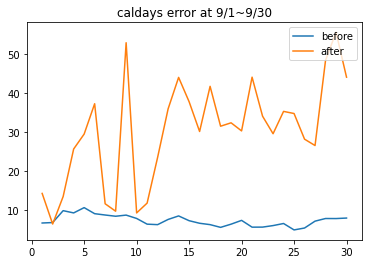

In [108]:
fig1 = plt.figure(1)
x=np.linspace(1,30,30)
plt.plot(x,before_error, label = 'before')
plt.plot(x,after_error, label ='after')
plt.legend(loc = 1)
plt.title('caldays error at 9/1~9/30')

plt.show()

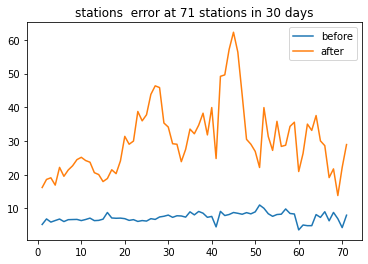

In [110]:
fig1 = plt.figure(1)
x=np.linspace(1,71,71)
plt.plot(x,before_sta, label = 'before')
plt.plot(x,after_sta, label ='after')
plt.legend(loc = 1)
plt.title('stations  error at 71 stations in 30 days')

plt.show()

# PCA(99%)

## pca

In [27]:
pca99 = PCA(n_components=0.99)
pca99.fit(new_x)

PCA(n_components=0.99)

In [28]:
x_pca99=pca99.transform(new_x)
print(x_pca99.shape)
print(np.linalg.matrix_rank(x_pca99))

(22944, 763)
763


## beta

In [29]:
beta1_2=np.dot( np.linalg.inv( np.dot( x_pca99.T,x_pca99 ) )  ,  np.dot( x_pca99.T,new_y )  )
print(np.shape(beta1_2))

(763, 6816)


## fit Y (base on training data)

In [30]:
new_Ybar=np.zeros([239*96,6816])
for i in range (0,239*96):
    new_Ybar[i]=Ybar
print(np.shape(new_Ybar))

(22944, 6816)


In [31]:
fit_y2=new_Ybar+np.dot(x_pca99  , beta1_2)
print(np.shape(fit_y2))

(22944, 6816)


In [32]:
fit99=np.zeros([239,6816])
for i in range (0,96):
    for j in range (0,239):
        for k in range (0,71):
            fit99[j][96*k+i]=fit_y2[239*i+j][96*k+i]
print(np.shape(fit99))

(239, 6816)


In [34]:
fit99_mean=np.zeros([239,6816])
for i in range (0,239):
    for j in range (0,6816):
        for k in range (0,96):
            fit99_mean[i][j]=fit99_mean[i][j]+fit_y2[239*k+i][j]/96
print(np.shape(fit99_mean))

(239, 6816)


## compare(training data)

In [33]:
k=0
s=0
# missing data number of data_cal
for i in range (0,243):
    a=np.array(data['cal_PMf'][6816*i:6816*i+6816])
    for j in range(0,6816):
        if a[j]=='\\N' :
            k=k+1

#missing data number of data_obs
for i in range (0,243):
    a=np.array(data['obs_PMf'][6816*i:6816*i+6816])
    for j in range(0,6816):
        if a[j]=='\\N' :
            s=s+1
print(k)
print(s)

7996
44464


In [35]:
fit99_test=fit99
fit99_mean_test=fit99_mean

In [36]:
old_x=np.zeros([239,6816])
old_y=np.zeros([239,6816])
#data_cal
for i in range (1,240):
    a=np.array(data['cal_PMf'][6816*i:6816*i+6816])
    for j in range(0,6816):
        if a[j]=='\\N' :
            a[j]=0
    old_x[i-1]=a
#data_obs
for i in range (1,240):
    a=np.array(data['obs_PMf'][6816*i:6816*i+6816])
    for j in range(0,6816):
        if a[j]=='\\N' :
            a[j]=0
    old_y[i-1]=a
#Delete missing data
for i in range(0,239):
    for j in range(6816):
        if old_x[i][j]==0:
            old_y[i][j]=0
            fit99_test[i][j]=0
            fit99_mean_test[i][j]=0
        if old_y[i][j]==0:
            old_x[i][j]=0
            fit99_test[i][j]=0
            fit99_mean_test[i][j]=0
print(np.shape(old_x))
print(np.shape(old_y))
print(np.shape(fit99_test))
print(np.shape(fit99_mean_test))

(239, 6816)
(239, 6816)
(239, 6816)
(239, 6816)


In [37]:
before_error=0
after_error1=0
after_error2=0
for i in range (0,239):
    for j in range(0,6816):
        before_error=before_error+abs(old_x[i][j]-old_y[i][j])
        after_error1=after_error1+abs(fit99_test[i][j]-old_y[i][j])
        after_error2=after_error2+abs(fit99_mean_test[i][j]-old_y[i][j])
before_error=before_error/239/6816
after_error1=after_error1/239/6816
after_error2=after_error2/239/6816
print("January to August (training data set) before_error: %f" %before_error)
print("January to August (training data set) after_error of 99: %f" %after_error1)
print("January to August (training data set) after_error of 99_mean: %f" %after_error2)

January to August (training data set) before_error: 7.960098
January to August (training data set) after_error of 99: 8.160373
January to August (training data set) after_error of 99_mean: 8.159379


## compare(testing data)

In [78]:
k=0
s=0
#missing data number data_cal
for i in range (244,274):
    a=np.array(data['cal_PMf'][6816*i:6816*i+6816])
    for j in range(0,6816):
        if a[j]=='\\N' :
            k=k+1

#missing data number data_obs
for i in range (244,274):
    a=np.array(data['obs_PMf'][6816*i:6816*i+6816])
    for j in range(0,6816):
        if a[j]=='\\N' :
            s=s+1
print(k)
print(s)

680
3124


In [79]:
old_x=np.zeros([274,6816])
old_y=np.zeros([274,6816])
bigx=np.zeros([273,8520])
#data_cal
for i in range (0,274):
    a=np.array(data['cal_PMf'][6816*i:6816*i+6816])
    for j in range(0,6816):
        if a[j]=='\\N' :
            a[j]=np.nan
    old_x[i]=a
#data_obs
for i in range (0,274):
    a=np.array(data['obs_PMf'][6816*i:6816*i+6816])
    for j in range(0,6816):
        if a[j]=='\\N' :
            a[j]=np.nan
    old_y[i]=a
#x=x1 mix x2
for i in range (0,273):
    for j in range(0,1704):
        bigx[i][j]=old_y[i][j]
for i in range (1,274):  
    for j in range(1704,8520):
        bigx[i-1][j]=old_y[i][j-1704]
print(np.shape(old_x))
print(np.shape(old_y))
print(np.shape(bigx))

(274, 6816)
(274, 6816)
(273, 8520)


In [80]:
x=np.zeros([30,8520])
for i in range (0,30):
    for j in range (0,1704):
        x[i][j]=old_y[i+243][j]
    for j in range (1704,8520):
        x[i][j]=old_x[i+244][j-1704]
print(np.shape(x))

(30, 8520)


In [81]:
xf=np.zeros([30,8520])
xa=bigx
a=273
for i in range (30):
    xa=np.insert(xa,a,x[i],0)
    xb=sinkr.dineof(xa)
    xc=xb[0]
    xf[i]=xc[a]
    a=a+1
print(np.shape(xf))

[1]
 "1 EOF ; RMS = 7.66895649"


[1]
 "1 EOF ; RMS = 7.63953821"


[1]
 "1 EOF ; RMS = 7.63916078"


[1]
 "1 EOF ; RMS = 7.63913707"


[1]
 "1 EOF ; RMS = 7.63913296"


[1]
 "2 EOF ; RMS = 7.00917862"


[1]
 "2 EOF ; RMS = 7.00832297"


[1]
 "2 EOF ; RMS = 7.00833803"


[1]
 "3 EOF ; RMS = 6.55194875"


[1]
 "3 EOF ; RMS = 6.55110348"


[1]
 "3 EOF ; RMS = 6.55120764"


[1]
 "4 EOF ; RMS = 6.27469344"


[1]
 "4 EOF ; RMS = 6.27646068"


[1]
 "5 EOF ; RMS = 6.11984131"


[1]
 "5 EOF ; RMS = 6.1202528"


[1]
 "6 EOF ; RMS = 5.97344197"


[1]
 "6 EOF ; RMS = 5.97396437"


[1]
 "7 EOF ; RMS = 5.85064885"


[1]
 "7 EOF ; RMS = 5.85303802"


[1]
 "8 EOF ; RMS = 5.77578176"


[1]
 "8 EOF ; RMS = 5.77902356"


[1]
 "9 EOF ; RMS = 5.69732169"


[1]
 "9 EOF ; RMS = 5.70070722"


[1]
 "10 EOF ; RMS = 5.61246466"


[1]
 "10 EOF ; RMS = 5.6144513"


[1]
 "11 EOF ; RMS = 5.54320696"


[1]
 "11 EOF ; RMS = 5.54637126"


[1]
 "12 EOF ; RMS = 5.48177361"


[1]
 "12 EOF ; RMS = 5.48622271"


[1]
 "13 E

In [82]:
xcal=xf
for i in range (0,30):
    for j in range (0,8520):
        xcal[i][j]=xcal[i][j]-Xbar[j]
print(np.shape(xcal))

(30, 8520)


In [84]:
new_xcal=np.zeros([30,763])
for i in range (0,30):
    daycal=np.zeros([1,8520])
    for j in range (0,8520):
        daycal[0][j]=xcal[i][j]
    new_xcal[i]=pca99.transform(daycal)
print(new_xcal.shape)

(30, 763)


In [85]:
new_Ybar=np.zeros([30,6816])
for i in range (0,30):
    new_Ybar[i]=Ybar

In [86]:
new_xfit=new_Ybar+np.dot(new_xcal, beta1_2)
# new_xfit=np.dot(new_xcal, beta1_2)
print(np.shape(new_xfit))

(30, 6816)


In [87]:
old_x=np.zeros([30,6816])
old_y=np.zeros([30,6816])
#data_cal
for i in range (244,274):
    a=np.array(data['cal_PMf'][6816*i:6816*i+6816])
    for j in range(0,6816):
        if a[j]=='\\N' :
            a[j]=0
    old_x[i-244]=a
#data_obs
for i in range (244,274):
    a=np.array(data['obs_PMf'][6816*i:6816*i+6816])
    for j in range(0,6816):
        if a[j]=='\\N' :
            a[j]=0
    old_y[i-244]=a
#Delete missing data
for i in range(0,30):
    for j in range(6816):
        if old_x[i][j]==0:
            old_y[i][j]=0
            new_xfit[i][j]=0
        if old_y[i][j]==0:
            old_x[i][j]=0
            new_xfit[i][j]=0
print(np.shape(old_x))
print(np.shape(old_y))
print(np.shape(new_xfit))

(30, 6816)
(30, 6816)
(30, 6816)


In [88]:
before_error=np.zeros(30)
after_error=np.zeros(30)
before_sta=np.zeros(71)
after_sta=np.zeros(71)
for i in range (0,30):
    a=0
    b=0
    for j in range(0,6816):
        a=a+abs(old_x[i][j]-old_y[i][j])
        b=b+abs(new_xfit[i][j]-old_y[i][j])
    before_error[i]=a/6816
    after_error[i]=b/6816
print(before_error.shape)
print(after_error.shape)

for i in range (0,71):
    c=0
    d=0
    for j in range (0,30):
        for k in range (96*i,96*i+96):
            c=c+abs(old_x[j][k]-old_y[j][k])
            d=d+abs(new_xfit[j][k]-old_y[j][k])
    before_sta[i]=c/96/30
    after_sta[i]=d/96/30
print(before_sta.shape)
print(after_sta.shape)

(30,)
(30,)
(71,)
(71,)


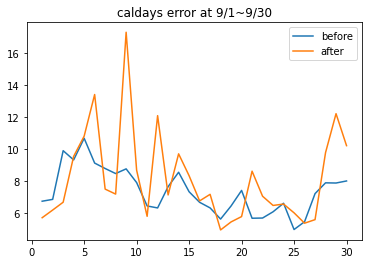

In [89]:
fig1 = plt.figure(1)
x=np.linspace(1,30,30)
plt.plot(x,before_error, label = 'before')
plt.plot(x,after_error, label ='after')
plt.legend(loc = 1)
plt.title('caldays error at 9/1~9/30')

plt.show()

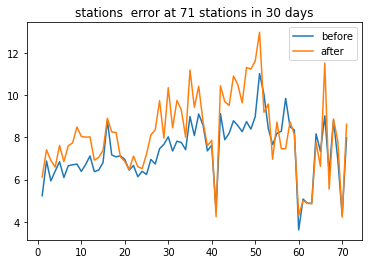

In [92]:
fig1 = plt.figure(1)
x=np.linspace(1,71,71)
plt.plot(x,before_sta, label = 'before')
plt.plot(x,after_sta, label ='after')
plt.legend(loc = 1)
plt.title('stations  error at 71 stations in 30 days')

plt.show()

# PCA(99.5)

## pca

In [111]:
pca995 = PCA(n_components=0.995)
pca995.fit(new_x)

PCA(n_components=0.995)

In [112]:
x_pca995=pca995.transform(new_x)
print(x_pca995.shape)
print(np.linalg.matrix_rank(x_pca995))

(22944, 1559)
1559


## beta

In [113]:
beta1_3=np.dot( np.linalg.inv( np.dot( x_pca995.T,x_pca995 ) )  ,  np.dot( x_pca995.T,new_y )  )
print(np.shape(beta1_3))

(1559, 6816)


## fit Y (base on training data)

In [114]:
new_Ybar=np.zeros([239*96,6816])
for i in range (0,239*96):
    new_Ybar[i]=Ybar
print(np.shape(new_Ybar))

(22944, 6816)


In [115]:
fit_y3=new_Ybar+np.dot(x_pca995  , beta1_3)
print(np.shape(fit_y3))

(22944, 6816)


In [116]:
fit995=np.zeros([239,6816])
for i in range (0,96):
    for j in range (0,239):
        for k in range (0,71):
            fit995[j][96*k+i]=fit_y3[239*i+j][96*k+i]
print(np.shape(fit995))

(239, 6816)


In [117]:
fit995_mean=np.zeros([239,6816])
for i in range (0,239):
    for j in range (0,6816):
        for k in range (0,96):
            fit995_mean[i][j]=fit995_mean[i][j]+fit_y3[239*k+i][j]/96
print(np.shape(fit995_mean))

(239, 6816)


## compare(training data)

In [118]:
k=0
s=0
# missing data number of data_cal
for i in range (0,243):
    a=np.array(data['cal_PMf'][6816*i:6816*i+6816])
    for j in range(0,6816):
        if a[j]=='\\N' :
            k=k+1

#missing data number of data_obs
for i in range (0,243):
    a=np.array(data['obs_PMf'][6816*i:6816*i+6816])
    for j in range(0,6816):
        if a[j]=='\\N' :
            s=s+1
print(k)
print(s)

7996
44464


In [119]:
fit995_test=fit995
fit995_mean_test=fit995_mean

In [120]:
old_x=np.zeros([239,6816])
old_y=np.zeros([239,6816])
#data_cal
for i in range (1,240):
    a=np.array(data['cal_PMf'][6816*i:6816*i+6816])
    for j in range(0,6816):
        if a[j]=='\\N' :
            a[j]=0
    old_x[i-1]=a
#data_obs
for i in range (1,240):
    a=np.array(data['obs_PMf'][6816*i:6816*i+6816])
    for j in range(0,6816):
        if a[j]=='\\N' :
            a[j]=0
    old_y[i-1]=a
#Delete missing data
for i in range(0,239):
    for j in range(6816):
        if old_x[i][j]==0:
            old_y[i][j]=0
            fit995_test[i][j]=0
            fit995_mean_test[i][j]=0
        if old_y[i][j]==0:
            old_x[i][j]=0
            fit995_test[i][j]=0
            fit995_mean_test[i][j]=0
print(np.shape(old_x))
print(np.shape(old_y))
print(np.shape(fit995_test))
print(np.shape(fit995_mean_test))

(239, 6816)
(239, 6816)
(239, 6816)
(239, 6816)


In [121]:
before_error=0
after_error1=0
after_error2=0
for i in range (0,239):
    for j in range(0,6816):
        before_error=before_error+abs(old_x[i][j]-old_y[i][j])
        after_error1=after_error1+abs(fit995_test[i][j]-old_y[i][j])
        after_error2=after_error2+abs(fit995_mean_test[i][j]-old_y[i][j])
before_error=before_error/239/6816
after_error1=after_error1/239/6816
after_error2=after_error2/239/6816
print("January to August (training data set) before_error: %f" %before_error)
print("January to August (training data set) after_error of 995: %f" %after_error1)
print("January to August (training data set) after_error of 995_mean: %f" %after_error2)

January to August (training data set) before_error: 7.960098
January to August (training data set) after_error of 995: 8.159978
January to August (training data set) after_error of 995_mean: 8.159427


## compare(testing data)

In [122]:
k=0
s=0
#missing data number data_cal
for i in range (244,274):
    a=np.array(data['cal_PMf'][6816*i:6816*i+6816])
    for j in range(0,6816):
        if a[j]=='\\N' :
            k=k+1

#missing data number data_obs
for i in range (244,274):
    a=np.array(data['obs_PMf'][6816*i:6816*i+6816])
    for j in range(0,6816):
        if a[j]=='\\N' :
            s=s+1
print(k)
print(s)

680
3124


In [123]:
old_x=np.zeros([274,6816])
old_y=np.zeros([274,6816])
bigx=np.zeros([273,8520])
#data_cal
for i in range (0,274):
    a=np.array(data['cal_PMf'][6816*i:6816*i+6816])
    for j in range(0,6816):
        if a[j]=='\\N' :
            a[j]=np.nan
    old_x[i]=a
#data_obs
for i in range (0,274):
    a=np.array(data['obs_PMf'][6816*i:6816*i+6816])
    for j in range(0,6816):
        if a[j]=='\\N' :
            a[j]=np.nan
    old_y[i]=a
#x=x1 mix x2
for i in range (0,273):
    for j in range(0,1704):
        bigx[i][j]=old_y[i][j]
for i in range (1,274):  
    for j in range(1704,8520):
        bigx[i-1][j]=old_y[i][j-1704]
print(np.shape(old_x))
print(np.shape(old_y))
print(np.shape(bigx))

(274, 6816)
(274, 6816)
(273, 8520)


In [124]:
x=np.zeros([30,8520])
for i in range (0,30):
    for j in range (0,1704):
        x[i][j]=old_y[i+243][j]
    for j in range (1704,8520):
        x[i][j]=old_x[i+244][j-1704]
print(np.shape(x))

(30, 8520)


In [132]:
xf=np.zeros([30,8520])
xa=bigx
a=273
for i in range (30):
    xa=np.insert(xa,a,x[i],0)
    xb=sinkr.dineof(xa)
    xc=xb[0]
    xf[i]=xc[a]
    a=a+1
print(np.shape(xf))

[1]
 "1 EOF ; RMS = 7.80664308"


[1]
 "1 EOF ; RMS = 7.77741224"


[1]
 "1 EOF ; RMS = 7.77722212"


[1]
 "1 EOF ; RMS = 7.77723288"


[1]
 "2 EOF ; RMS = 7.13704883"


[1]
 "2 EOF ; RMS = 7.1355688"


[1]
 "2 EOF ; RMS = 7.1355456"


[1]
 "2 EOF ; RMS = 7.13553748"


[1]
 "3 EOF ; RMS = 6.69715219"


[1]
 "3 EOF ; RMS = 6.69706255"


[1]
 "3 EOF ; RMS = 6.69714189"


[1]
 "4 EOF ; RMS = 6.38606134"


[1]
 "4 EOF ; RMS = 6.38618682"


[1]
 "5 EOF ; RMS = 6.22275953"


[1]
 "5 EOF ; RMS = 6.22251997"


[1]
 "5 EOF ; RMS = 6.22252224"


[1]
 "6 EOF ; RMS = 6.09586612"


[1]
 "6 EOF ; RMS = 6.09814935"


[1]
 "7 EOF ; RMS = 5.97001094"


[1]
 "7 EOF ; RMS = 5.9716335"


[1]
 "8 EOF ; RMS = 5.8601674"


[1]
 "8 EOF ; RMS = 5.86176858"


[1]
 "9 EOF ; RMS = 5.77914116"


[1]
 "9 EOF ; RMS = 5.78221422"


[1]
 "10 EOF ; RMS = 5.70353368"


[1]
 "10 EOF ; RMS = 5.70703296"


[1]
 "11 EOF ; RMS = 5.63347666"


[1]
 "11 EOF ; RMS = 5.63716137"


[1]
 "12 EOF ; RMS = 5.55793749"


[1]
 "12 EOF 

In [133]:
xcal=xf
for i in range (0,30):
    for j in range (0,8520):
        xcal[i][j]=xcal[i][j]-Xbar[j]
print(np.shape(xcal))

(30, 8520)


In [134]:
new_xcal=np.zeros([30,np.shape(x_pca995)[1]])
for i in range (0,30):
    daycal=np.zeros([1,8520])
    for j in range (0,8520):
        daycal[0][j]=xcal[i][j]
    new_xcal[i]=pca995.transform(daycal)
print(new_xcal.shape)

(30, 1559)


In [135]:
new_Ybar=np.zeros([30,6816])
for i in range (0,30):
    new_Ybar[i]=Ybar

In [136]:
new_xfit=new_Ybar+np.dot(new_xcal, beta1_3)
# new_xfit=np.dot(new_xcal, beta1_3)
print(np.shape(new_xfit))

(30, 6816)


In [137]:
old_x=np.zeros([30,6816])
old_y=np.zeros([30,6816])
#data_cal
for i in range (244,274):
    a=np.array(data['cal_PMf'][6816*i:6816*i+6816])
    for j in range(0,6816):
        if a[j]=='\\N' :
            a[j]=0
    old_x[i-244]=a
#data_obs
for i in range (244,274):
    a=np.array(data['obs_PMf'][6816*i:6816*i+6816])
    for j in range(0,6816):
        if a[j]=='\\N' :
            a[j]=0
    old_y[i-244]=a
#Delete missing data
for i in range(0,30):
    for j in range(6816):
        if old_x[i][j]==0:
            old_y[i][j]=0
            new_xfit[i][j]=0
        if old_y[i][j]==0:
            old_x[i][j]=0
            new_xfit[i][j]=0
print(np.shape(old_x))
print(np.shape(old_y))
print(np.shape(new_xfit))

(30, 6816)
(30, 6816)
(30, 6816)


In [138]:
before_error=np.zeros(30)
after_error=np.zeros(30)
before_sta=np.zeros(71)
after_sta=np.zeros(71)
for i in range (0,30):
    a=0
    b=0
    for j in range(0,6816):
        a=a+abs(old_x[i][j]-old_y[i][j])
        b=b+abs(new_xfit[i][j]-old_y[i][j])
    before_error[i]=a/6816
    after_error[i]=b/6816
print(before_error.shape)
print(after_error.shape)

for i in range (0,71):
    c=0
    d=0
    for j in range (0,30):
        for k in range (96*i,96*i+96):
            c=c+abs(old_x[j][k]-old_y[j][k])
            d=d+abs(new_xfit[j][k]-old_y[j][k])
    before_sta[i]=c/96/30
    after_sta[i]=d/96/30
print(before_sta.shape)
print(after_sta.shape)

(30,)
(30,)
(71,)
(71,)


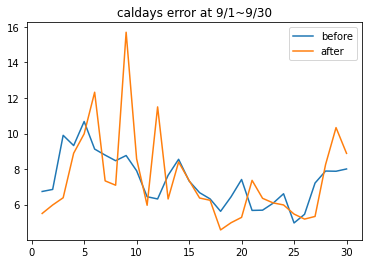

In [139]:
fig1 = plt.figure(1)
x=np.linspace(1,30,30)
plt.plot(x,before_error, label = 'before')
plt.plot(x,after_error, label ='after')
plt.legend(loc = 1)
plt.title('caldays error at 9/1~9/30')

plt.show()

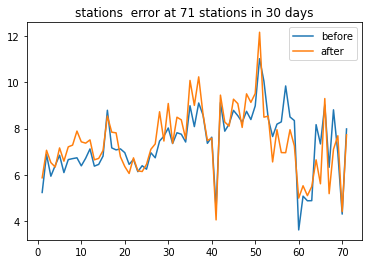

In [140]:
fig1 = plt.figure(1)
x=np.linspace(1,71,71)
plt.plot(x,before_sta, label = 'before')
plt.plot(x,after_sta, label ='after')
plt.legend(loc = 1)
plt.title('stations  error at 71 stations in 30 days')

plt.show()

# PCA(99.9)

## pca

In [141]:
pca999 = PCA(n_components=0.999)
pca999.fit(new_x)

PCA(n_components=0.999)

In [142]:
x_pca999=pca999.transform(new_x)
print(x_pca999.shape)
print(np.linalg.matrix_rank(x_pca999))

(22944, 3920)
3920


## beta

In [143]:
beta1_4=np.dot( np.linalg.inv( np.dot( x_pca999.T,x_pca999 ) )  ,  np.dot( x_pca999.T,new_y )  )
print(np.shape(beta1_4))

(3920, 6816)


## fit Y (base on training data)

In [144]:
new_Ybar=np.zeros([239*96,6816])
for i in range (0,239*96):
    new_Ybar[i]=Ybar
print(np.shape(new_Ybar))

(22944, 6816)


In [145]:
fit_y4=new_Ybar+np.dot(x_pca999  , beta1_4)
print(np.shape(fit_y4))

(22944, 6816)


In [146]:
fit999=np.zeros([239,6816])
for i in range (0,96):
    for j in range (0,239):
        for k in range (0,71):
            fit999[j][96*k+i]=fit_y4[239*i+j][96*k+i]
print(np.shape(fit999))

(239, 6816)


In [147]:
fit999_mean=np.zeros([239,6816])
for i in range (0,239):
    for j in range (0,6816):
        for k in range (0,96):
            fit999_mean[i][j]=fit999_mean[i][j]+fit_y4[239*k+i][j]/96
print(np.shape(fit999_mean))

(239, 6816)


## compare(training data)

In [148]:
k=0
s=0
# missing data number of data_cal
for i in range (0,243):
    a=np.array(data['cal_PMf'][6816*i:6816*i+6816])
    for j in range(0,6816):
        if a[j]=='\\N' :
            k=k+1

#missing data number of data_obs
for i in range (0,243):
    a=np.array(data['obs_PMf'][6816*i:6816*i+6816])
    for j in range(0,6816):
        if a[j]=='\\N' :
            s=s+1
print(k)
print(s)

7996
44464


In [149]:
fit999_test=fit999
fit999_mean_test=fit999_mean

In [150]:
old_x=np.zeros([239,6816])
old_y=np.zeros([239,6816])
#data_cal
for i in range (1,240):
    a=np.array(data['cal_PMf'][6816*i:6816*i+6816])
    for j in range(0,6816):
        if a[j]=='\\N' :
            a[j]=0
    old_x[i-1]=a
#data_obs
for i in range (1,240):
    a=np.array(data['obs_PMf'][6816*i:6816*i+6816])
    for j in range(0,6816):
        if a[j]=='\\N' :
            a[j]=0
    old_y[i-1]=a
#Delete missing data
for i in range(0,239):
    for j in range(6816):
        if old_x[i][j]==0:
            old_y[i][j]=0
            fit999_test[i][j]=0
            fit999_mean_test[i][j]=0
        if old_y[i][j]==0:
            old_x[i][j]=0
            fit999_test[i][j]=0
            fit999_mean_test[i][j]=0
print(np.shape(old_x))
print(np.shape(old_y))
print(np.shape(fit999_test))
print(np.shape(fit999_mean_test))

(239, 6816)
(239, 6816)
(239, 6816)
(239, 6816)


In [151]:
before_error=0
after_error1=0
after_error2=0
for i in range (0,239):
    for j in range(0,6816):
        before_error=before_error+abs(old_x[i][j]-old_y[i][j])
        after_error1=after_error1+abs(fit999_test[i][j]-old_y[i][j])
        after_error2=after_error2+abs(fit999_mean_test[i][j]-old_y[i][j])
before_error=before_error/239/6816
after_error1=after_error1/239/6816
after_error2=after_error2/239/6816
print("January to August (training data set) before_error: %f" %before_error)
print("January to August (training data set) after_error of 999: %f" %after_error1)
print("January to August (training data set) after_error of 999_mean: %f" %after_error2)

January to August (training data set) before_error: 7.960098
January to August (training data set) after_error of 999: 8.159633
January to August (training data set) after_error of 999_mean: 8.159439


## compare(testing data)

In [152]:
k=0
s=0
#missing data number data_cal
for i in range (244,274):
    a=np.array(data['cal_PMf'][6816*i:6816*i+6816])
    for j in range(0,6816):
        if a[j]=='\\N' :
            k=k+1

#missing data number data_obs
for i in range (244,274):
    a=np.array(data['obs_PMf'][6816*i:6816*i+6816])
    for j in range(0,6816):
        if a[j]=='\\N' :
            s=s+1
print(k)
print(s)

680
3124


In [153]:
old_x=np.zeros([274,6816])
old_y=np.zeros([274,6816])
bigx=np.zeros([273,8520])
#data_cal
for i in range (0,274):
    a=np.array(data['cal_PMf'][6816*i:6816*i+6816])
    for j in range(0,6816):
        if a[j]=='\\N' :
            a[j]=np.nan
    old_x[i]=a
#data_obs
for i in range (0,274):
    a=np.array(data['obs_PMf'][6816*i:6816*i+6816])
    for j in range(0,6816):
        if a[j]=='\\N' :
            a[j]=np.nan
    old_y[i]=a
#x=x1 mix x2
for i in range (0,273):
    for j in range(0,1704):
        bigx[i][j]=old_y[i][j]
for i in range (1,274):  
    for j in range(1704,8520):
        bigx[i-1][j]=old_y[i][j-1704]
print(np.shape(old_x))
print(np.shape(old_y))
print(np.shape(bigx))

(274, 6816)
(274, 6816)
(273, 8520)


In [154]:
x=np.zeros([30,8520])
for i in range (0,30):
    for j in range (0,1704):
        x[i][j]=old_y[i+243][j]
    for j in range (1704,8520):
        x[i][j]=old_x[i+244][j-1704]
print(np.shape(x))

(30, 8520)


In [155]:
xf=np.zeros([30,8520])
xa=bigx
a=273
for i in range (30):
    xa=np.insert(xa,a,x[i],0)
    xb=sinkr.dineof(xa)
    xc=xb[0]
    xf[i]=xc[a]
    a=a+1
print(np.shape(xf))

[1]
 "1 EOF ; RMS = 7.90385353"


[1]
 "1 EOF ; RMS = 7.86214238"


[1]
 "1 EOF ; RMS = 7.86085678"


[1]
 "1 EOF ; RMS = 7.86074311"


[1]
 "1 EOF ; RMS = 7.86072861"


[1]
 "1 EOF ; RMS = 7.86072651"


[1]
 "2 EOF ; RMS = 7.20182334"


[1]
 "2 EOF ; RMS = 7.1985016"


[1]
 "2 EOF ; RMS = 7.19836804"


[1]
 "2 EOF ; RMS = 7.19836052"


[1]
 "3 EOF ; RMS = 6.77531785"


[1]
 "3 EOF ; RMS = 6.77719107"


[1]
 "4 EOF ; RMS = 6.48223814"


[1]
 "4 EOF ; RMS = 6.48179785"


[1]
 "4 EOF ; RMS = 6.48193951"


[1]
 "5 EOF ; RMS = 6.32658363"


[1]
 "5 EOF ; RMS = 6.32602358"


[1]
 "5 EOF ; RMS = 6.32567921"


[1]
 "5 EOF ; RMS = 6.32544989"


[1]
 "5 EOF ; RMS = 6.32533642"


[1]
 "5 EOF ; RMS = 6.32528519"


[1]
 "5 EOF ; RMS = 6.32526283"


[1]
 "5 EOF ; RMS = 6.32525322"


[1]
 "6 EOF ; RMS = 6.17708526"


[1]
 "6 EOF ; RMS = 6.17823709"


[1]
 "7 EOF ; RMS = 6.04089301"


[1]
 "7 EOF ; RMS = 6.04208891"


[1]
 "8 EOF ; RMS = 5.95132898"


[1]
 "8 EOF ; RMS = 5.95093259"


[1]
 "8 EOF ; R

In [156]:
xcal=xf
for i in range (0,30):
    for j in range (0,8520):
        xcal[i][j]=xcal[i][j]-Xbar[j]
print(np.shape(xcal))

(30, 8520)


In [157]:
new_xcal=np.zeros([30,np.shape(x_pca999)[1]])
for i in range (0,30):
    daycal=np.zeros([1,8520])
    for j in range (0,8520):
        daycal[0][j]=xcal[i][j]
    new_xcal[i]=pca999.transform(daycal)
print(new_xcal.shape)

(30, 3920)


In [158]:
new_Ybar=np.zeros([30,6816])
for i in range (0,30):
    new_Ybar[i]=Ybar

In [159]:
new_xfit=new_Ybar+np.dot(new_xcal, beta1_4)
# new_xfit=np.dot(new_xcal, beta1_4)
print(np.shape(new_xfit))

(30, 6816)


In [160]:
old_x=np.zeros([30,6816])
old_y=np.zeros([30,6816])
#data_cal
for i in range (244,274):
    a=np.array(data['cal_PMf'][6816*i:6816*i+6816])
    for j in range(0,6816):
        if a[j]=='\\N' :
            a[j]=0
    old_x[i-244]=a
#data_obs
for i in range (244,274):
    a=np.array(data['obs_PMf'][6816*i:6816*i+6816])
    for j in range(0,6816):
        if a[j]=='\\N' :
            a[j]=0
    old_y[i-244]=a
#Delete missing data
for i in range(0,30):
    for j in range(6816):
        if old_x[i][j]==0:
            old_y[i][j]=0
            new_xfit[i][j]=0
        if old_y[i][j]==0:
            old_x[i][j]=0
            new_xfit[i][j]=0
print(np.shape(old_x))
print(np.shape(old_y))
print(np.shape(new_xfit))

(30, 6816)
(30, 6816)
(30, 6816)


In [161]:
before_error=np.zeros(30)
after_error=np.zeros(30)
before_sta=np.zeros(71)
after_sta=np.zeros(71)
for i in range (0,30):
    a=0
    b=0
    for j in range(0,6816):
        a=a+abs(old_x[i][j]-old_y[i][j])
        b=b+abs(new_xfit[i][j]-old_y[i][j])
    before_error[i]=a/6816
    after_error[i]=b/6816
print(before_error.shape)
print(after_error.shape)

for i in range (0,71):
    c=0
    d=0
    for j in range (0,30):
        for k in range (96*i,96*i+96):
            c=c+abs(old_x[j][k]-old_y[j][k])
            d=d+abs(new_xfit[j][k]-old_y[j][k])
    before_sta[i]=c/96/30
    after_sta[i]=d/96/30
print(before_sta.shape)
print(after_sta.shape)

(30,)
(30,)
(71,)
(71,)


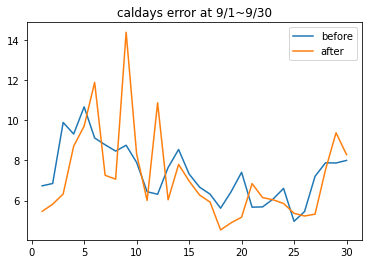

In [162]:
fig1 = plt.figure(1)
x=np.linspace(1,30,30)
plt.plot(x,before_error, label = 'before')
plt.plot(x,after_error, label ='after')
plt.legend(loc = 1)
plt.title('caldays error at 9/1~9/30')

plt.show()

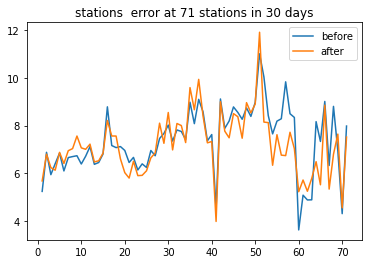

In [163]:
fig1 = plt.figure(1)
x=np.linspace(1,71,71)
plt.plot(x,before_sta, label = 'before')
plt.plot(x,after_sta, label ='after')
plt.legend(loc = 1)
plt.title('stations  error at 71 stations in 30 days')

plt.show()

# PCA(99.99)

## pca

In [164]:
pca9999 = PCA(n_components=0.9999)
pca9999.fit(new_x)

PCA(n_components=0.9999)

In [165]:
x_pca9999=pca9999.transform(new_x)
print(x_pca9999.shape)
print(np.linalg.matrix_rank(x_pca9999))

(22944, 6070)
6070


## beta

In [166]:
beta1_5=np.dot( np.linalg.inv( np.dot( x_pca9999.T,x_pca9999 ) )  ,  np.dot( x_pca9999.T,new_y )  )
print(np.shape(beta1_5))

(6070, 6816)


## fit Y (base on training data)

In [167]:
new_Ybar=np.zeros([239*96,6816])
for i in range (0,239*96):
    new_Ybar[i]=Ybar
print(np.shape(new_Ybar))

(22944, 6816)


In [168]:
fit_y5=new_Ybar+np.dot(x_pca9999  , beta1_5)
print(np.shape(fit_y5))

(22944, 6816)


In [169]:
fit9999=np.zeros([239,6816])
for i in range (0,96):
    for j in range (0,239):
        for k in range (0,71):
            fit9999[j][96*k+i]=fit_y5[239*i+j][96*k+i]
print(np.shape(fit9999))

(239, 6816)


In [170]:
fit9999_mean=np.zeros([239,6816])
for i in range (0,239):
    for j in range (0,6816):
        for k in range (0,96):
            fit9999_mean[i][j]=fit9999_mean[i][j]+fit_y5[239*k+i][j]/96
print(np.shape(fit9999_mean))

(239, 6816)


## compare(training data)

In [171]:
k=0
s=0
# missing data number of data_cal
for i in range (0,243):
    a=np.array(data['cal_PMf'][6816*i:6816*i+6816])
    for j in range(0,6816):
        if a[j]=='\\N' :
            k=k+1

#missing data number of data_obs
for i in range (0,243):
    a=np.array(data['obs_PMf'][6816*i:6816*i+6816])
    for j in range(0,6816):
        if a[j]=='\\N' :
            s=s+1
print(k)
print(s)

7996
44464


In [172]:
fit9999_test=fit9999
fit9999_mean_test=fit9999_mean

In [173]:
old_x=np.zeros([239,6816])
old_y=np.zeros([239,6816])
#data_cal
for i in range (1,240):
    a=np.array(data['cal_PMf'][6816*i:6816*i+6816])
    for j in range(0,6816):
        if a[j]=='\\N' :
            a[j]=0
    old_x[i-1]=a
#data_obs
for i in range (1,240):
    a=np.array(data['obs_PMf'][6816*i:6816*i+6816])
    for j in range(0,6816):
        if a[j]=='\\N' :
            a[j]=0
    old_y[i-1]=a
#Delete missing data
for i in range(0,239):
    for j in range(6816):
        if old_x[i][j]==0:
            old_y[i][j]=0
            fit9999_test[i][j]=0
            fit9999_mean_test[i][j]=0
        if old_y[i][j]==0:
            old_x[i][j]=0
            fit9999_test[i][j]=0
            fit9999_mean_test[i][j]=0
print(np.shape(old_x))
print(np.shape(old_y))
print(np.shape(fit9999_test))
print(np.shape(fit9999_mean_test))

(239, 6816)
(239, 6816)
(239, 6816)
(239, 6816)


In [174]:
before_error=0
after_error1=0
after_error2=0
for i in range (0,239):
    for j in range(0,6816):
        before_error=before_error+abs(old_x[i][j]-old_y[i][j])
        after_error1=after_error1+abs(fit9999_test[i][j]-old_y[i][j])
        after_error2=after_error2+abs(fit9999_mean_test[i][j]-old_y[i][j])
before_error=before_error/239/6816
after_error1=after_error1/239/6816
after_error2=after_error2/239/6816
print("January to August (training data set) before_error: %f" %before_error)
print("January to August (training data set) after_error of 9999: %f" %after_error1)
print("January to August (training data set) after_error of 9999_mean: %f" %after_error2)

January to August (training data set) before_error: 7.960098
January to August (training data set) after_error of 9999: 8.159492
January to August (training data set) after_error of 9999_mean: 8.159440


## compare(testing data)

In [175]:
k=0
s=0
#missing data number data_cal
for i in range (244,274):
    a=np.array(data['cal_PMf'][6816*i:6816*i+6816])
    for j in range(0,6816):
        if a[j]=='\\N' :
            k=k+1

#missing data number data_obs
for i in range (244,274):
    a=np.array(data['obs_PMf'][6816*i:6816*i+6816])
    for j in range(0,6816):
        if a[j]=='\\N' :
            s=s+1
print(k)
print(s)

680
3124


In [176]:
old_x=np.zeros([274,6816])
old_y=np.zeros([274,6816])
bigx=np.zeros([273,8520])
#data_cal
for i in range (0,274):
    a=np.array(data['cal_PMf'][6816*i:6816*i+6816])
    for j in range(0,6816):
        if a[j]=='\\N' :
            a[j]=np.nan
    old_x[i]=a
#data_obs
for i in range (0,274):
    a=np.array(data['obs_PMf'][6816*i:6816*i+6816])
    for j in range(0,6816):
        if a[j]=='\\N' :
            a[j]=np.nan
    old_y[i]=a
#x=x1 mix x2
for i in range (0,273):
    for j in range(0,1704):
        bigx[i][j]=old_y[i][j]
for i in range (1,274):  
    for j in range(1704,8520):
        bigx[i-1][j]=old_y[i][j-1704]
print(np.shape(old_x))
print(np.shape(old_y))
print(np.shape(bigx))

(274, 6816)
(274, 6816)
(273, 8520)


In [177]:
x=np.zeros([30,8520])
for i in range (0,30):
    for j in range (0,1704):
        x[i][j]=old_y[i+243][j]
    for j in range (1704,8520):
        x[i][j]=old_x[i+244][j-1704]
print(np.shape(x))

(30, 8520)


In [178]:
xf=np.zeros([30,8520])
xa=bigx
a=273
for i in range (30):
    xa=np.insert(xa,a,x[i],0)
    xb=sinkr.dineof(xa)
    xc=xb[0]
    xf[i]=xc[a]
    a=a+1
print(np.shape(xf))

[1]
 "1 EOF ; RMS = 7.80516731"


[1]
 "1 EOF ; RMS = 7.77310109"


[1]
 "1 EOF ; RMS = 7.77285648"


[1]
 "1 EOF ; RMS = 7.77288812"


[1]
 "2 EOF ; RMS = 7.17153811"


[1]
 "2 EOF ; RMS = 7.17224228"


[1]
 "3 EOF ; RMS = 6.73319746"


[1]
 "3 EOF ; RMS = 6.7319079"


[1]
 "3 EOF ; RMS = 6.73179622"


[1]
 "3 EOF ; RMS = 6.73177497"


[1]
 "3 EOF ; RMS = 6.73177103"


[1]
 "4 EOF ; RMS = 6.41133587"


[1]
 "4 EOF ; RMS = 6.41028593"


[1]
 "4 EOF ; RMS = 6.41033129"


[1]
 "5 EOF ; RMS = 6.2455292"


[1]
 "5 EOF ; RMS = 6.24508059"


[1]
 "5 EOF ; RMS = 6.24524086"


[1]
 "6 EOF ; RMS = 6.11704945"


[1]
 "6 EOF ; RMS = 6.11890418"


[1]
 "7 EOF ; RMS = 5.98396854"


[1]
 "7 EOF ; RMS = 5.98495063"


[1]
 "8 EOF ; RMS = 5.88534261"


[1]
 "8 EOF ; RMS = 5.88594654"


[1]
 "9 EOF ; RMS = 5.79765492"


[1]
 "9 EOF ; RMS = 5.79954656"


[1]
 "10 EOF ; RMS = 5.71460189"


[1]
 "10 EOF ; RMS = 5.71733333"


[1]
 "11 EOF ; RMS = 5.63613007"


[1]
 "11 EOF ; RMS = 5.6373653"


[1]
 "12 EOF 

In [179]:
xcal=xf
for i in range (0,30):
    for j in range (0,8520):
        xcal[i][j]=xcal[i][j]-Xbar[j]
print(np.shape(xcal))

(30, 8520)


In [180]:
new_xcal=np.zeros([30,np.shape(x_pca9999)[1]])
for i in range (0,30):
    daycal=np.zeros([1,8520])
    for j in range (0,8520):
        daycal[0][j]=xcal[i][j]
    new_xcal[i]=pca9999.transform(daycal)
print(new_xcal.shape)

(30, 6070)


In [181]:
new_Ybar=np.zeros([30,6816])
for i in range (0,30):
    new_Ybar[i]=Ybar

In [182]:
new_xfit=new_Ybar+np.dot(new_xcal, beta1_5)
# new_xfit=np.dot(new_xcal, beta1_5)
print(np.shape(new_xfit))

(30, 6816)


In [183]:
old_x=np.zeros([30,6816])
old_y=np.zeros([30,6816])
#data_cal
for i in range (244,274):
    a=np.array(data['cal_PMf'][6816*i:6816*i+6816])
    for j in range(0,6816):
        if a[j]=='\\N' :
            a[j]=0
    old_x[i-244]=a
#data_obs
for i in range (244,274):
    a=np.array(data['obs_PMf'][6816*i:6816*i+6816])
    for j in range(0,6816):
        if a[j]=='\\N' :
            a[j]=0
    old_y[i-244]=a
#Delete missing data
for i in range(0,30):
    for j in range(6816):
        if old_x[i][j]==0:
            old_y[i][j]=0
            new_xfit[i][j]=0
        if old_y[i][j]==0:
            old_x[i][j]=0
            new_xfit[i][j]=0
print(np.shape(old_x))
print(np.shape(old_y))
print(np.shape(new_xfit))

(30, 6816)
(30, 6816)
(30, 6816)


In [184]:
before_error=np.zeros(30)
after_error=np.zeros(30)
before_sta=np.zeros(71)
after_sta=np.zeros(71)
for i in range (0,30):
    a=0
    b=0
    for j in range(0,6816):
        a=a+abs(old_x[i][j]-old_y[i][j])
        b=b+abs(new_xfit[i][j]-old_y[i][j])
    before_error[i]=a/6816
    after_error[i]=b/6816
print(before_error.shape)
print(after_error.shape)

for i in range (0,71):
    c=0
    d=0
    for j in range (0,30):
        for k in range (96*i,96*i+96):
            c=c+abs(old_x[j][k]-old_y[j][k])
            d=d+abs(new_xfit[j][k]-old_y[j][k])
    before_sta[i]=c/96/30
    after_sta[i]=d/96/30
print(before_sta.shape)
print(after_sta.shape)

(30,)
(30,)
(71,)
(71,)


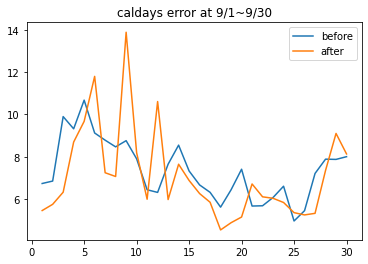

In [185]:
fig1 = plt.figure(1)
x=np.linspace(1,30,30)
plt.plot(x,before_error, label = 'before')
plt.plot(x,after_error, label ='after')
plt.legend(loc = 1)
plt.title('caldays error at 9/1~9/30')

plt.show()

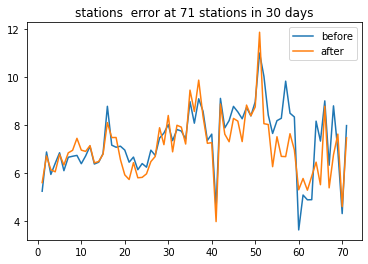

In [186]:
fig1 = plt.figure(1)
x=np.linspace(1,71,71)
plt.plot(x,before_sta, label = 'before')
plt.plot(x,after_sta, label ='after')
plt.legend(loc = 1)
plt.title('stations  error at 71 stations in 30 days')

plt.show()